# Import Libraries

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold

# Import Dataset

In [2]:
df = pd.read_csv('data.csv')

# Data Preparation

In [3]:
df = df[['Make', 'Model', 'Year', 'Engine HP', 'Engine Cylinders',
          'Transmission Type', 'Vehicle Style', 'highway MPG', 'city mpg', 'MSRP']]
df.columns = df.columns.str.replace(' ', '_').str.lower()
df.fillna(0, inplace=True)
mean_price = df['msrp'].mean()
df['above_average']=(df['msrp'] > mean_price).astype(int)
df.head()   

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,msrp,above_average
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135,1
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650,1
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,36350,0
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,29450,0
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,34500,0


# Split Dataset

In [4]:
seed = 1
df_train, df_temp = train_test_split(df, test_size=0.4, random_state=seed)
df_val, df_test = train_test_split(df_temp, test_size=0.2, random_state=seed)

# def extract_features_target(dataset):
#     X = dataset.drop(columns=['price'])
#     y = dataset['price']
#     return X, y
# X_train, y_train = extract_features_target(train_df)
# X_val, y_val = extract_features_target(val_df)
# X_test, y_test = extract_features_target(test_df)

# Question 1

In [8]:
# Pilih hanya kolom-kolom dengan tipe data numerik
numerical_columns = df_train.select_dtypes(include=['number']).columns

# List untuk menyimpan nama kolom dan AUC mereka
auc_values = []
# Loop melalui setiap kolom numerik untuk menghitung AUC
for col in numerical_columns:
    # Jangan gunakan variabel target itu sendiri
    if col == 'above_average':
        continue
    
    # Hitung AUC
    auc = roc_auc_score(df_train['above_average'], df_train[col])
    
    # Jika AUC < 0.5, balik arah korelasi
    if auc < 0.5:
        df_train[col] = -df_train[col]
        auc = 1 - auc  # Update nilai AUC
    
    # Menyimpan nama kolom dan AUC-nya
    auc_values.append((col, auc))

# Urutkan berdasarkan AUC tertinggi
sorted_auc_values = sorted(auc_values, key=lambda x: x[1], reverse=True)

# Cetak nilai AUC untuk setiap kolom
for col, auc in sorted_auc_values:
    print(f"{col}: {auc}")

msrp: 1.0
engine_hp: 0.9159001518508375
engine_cylinders: 0.768274900593613
year: 0.6943018002799936
city_mpg: 0.67232674562278
highway_mpg: 0.6333685399678282


Among the option, the numerical variable with the highest AUC is **engine_hp**

# Question 2

In [11]:
# Tentukan kolom target
target = 'above_average'

# Konversi ke dictionary
train_dict = df_train.drop(columns=[target]).to_dict(orient='records')
val_dict = df_val.drop(columns=[target]).to_dict(orient='records')

# Apply One-Hot Encoding
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)

# Label target
y_train = df_train[target].values
y_val = df_val[target].values

# Train the logistic regression model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

# Prediksi probabilitas kelas positif
y_pred_val = model.predict_proba(X_val)[:, 1]

# Hitung AUC pada dataset validasi
auc = roc_auc_score(y_val, y_pred_val)

# Bulatkan AUC ke 3 angka desimal
# rounded_auc = round(auc, 3)

print(f"The AUC of the model on the validation dataset is: {auc}")

The AUC of the model on the validation dataset is: 0.9999982779522786


The closest AUC on the validatio dataset is *0.979*

# Question 3

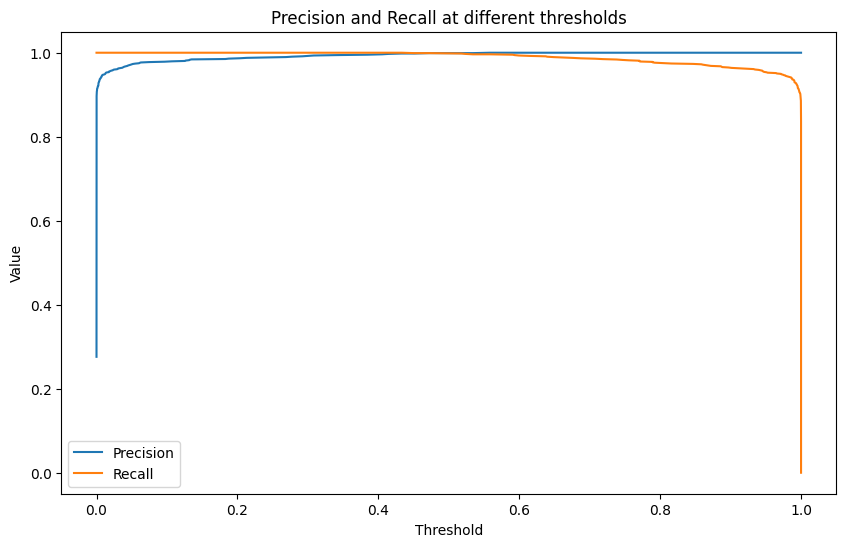

The curves intersect at threshold: 0.4723468544113183


In [13]:
# Menghitung precision dan recall untuk setiap threshold
precision, recall, thresholds = precision_recall_curve(y_val, y_pred_val)

# Menambahkan threshold 1.0 ke akhir array thresholds
thresholds = np.append(thresholds, 1)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision, label='Precision')
plt.plot(thresholds, recall, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Value')
plt.title('Precision and Recall at different thresholds')
plt.legend()
plt.show()

# Menemukan titik potong antara precision dan recall
intersect_thresholds = thresholds[np.argmin(np.abs(precision - recall))]
print(f"The curves intersect at threshold: {intersect_thresholds}")

The closest threshold precision and recall curves intersect is **0.48**

# Question 4

In [17]:
# Inisialisasi variabel
max_f1 = 0
threshold_at_max_f1 = 0
f1_scores = []

# Menghitung F1 untuk semua ambang batas
for t in np.arange(0.0, 1.01, 0.01):
    y_pred = (y_pred_val >= t).astype(int)
    f1 = f1_score(y_val, y_pred)
    f1_scores.append(f1)
    
    if f1 > max_f1:
        max_f1 = f1
        threshold_at_max_f1 = t

print(f"Maximal F1 score is {max_f1} at threshold {threshold_at_max_f1}")

Maximal F1 score is 0.9990503323836657 at threshold 0.42


In [21]:
# Inisialisasi
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
target = 'above_average'
auc_scores = []

df_full_train = df_train.copy()

# One-hot encoding
dv = DictVectorizer(sparse=False)
df_dict = df_full_train.drop(columns=[target]).to_dict(orient='records')
X_full_train = dv.fit_transform(df_dict)
y_full_train = df_full_train[target].values

# Iterasi melalui fold
for train_index, val_index in kfold.split(X_full_train):
    # Membagi data
    X_train, X_val = X_full_train[train_index], X_full_train[val_index]
    y_train, y_val = y_full_train[train_index], y_full_train[val_index]
    
    # Melatih model
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)
    
    # Evaluasi model
    y_pred = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    auc_scores.append(auc)

# Menghitung deviasi standar dari skor AUC
std_dev = np.std(auc_scores)

print(f"AUC scores for each fold: {auc_scores}")
print(f"Standard deviation of AUC scores across different folds: {std_dev}")


AUC scores for each fold: [1.0, 0.9999805825242718, 0.9999899067382615, 1.0, 1.0]
Standard deviation of AUC scores across different folds: 7.806863275496692e-06


In [22]:
# Parameter
Cs = [0.01, 0.1, 0.5, 10]
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
target = 'above_average'

# One-hot encoding
dv = DictVectorizer(sparse=False)
df_dict = df_full_train.drop(columns=[target]).to_dict(orient='records')
X_full_train = dv.fit_transform(df_dict)
y_full_train = df_full_train[target].values

# Inisialisasi variabel
best_mean_score = 0
best_C = None
best_std = None

# Iterasi melalui nilai C
for C in Cs:
    auc_scores = []
    
    # Iterasi melalui fold
    for train_index, val_index in kfold.split(X_full_train):
        # Membagi data
        X_train, X_val = X_full_train[train_index], X_full_train[val_index]
        y_train, y_val = y_full_train[train_index], y_full_train[val_index]
        
        # Melatih model
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train, y_train)
        
        # Evaluasi model
        y_pred = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        auc_scores.append(auc)
        
    # Menghitung mean dan std
    mean_score = np.mean(auc_scores)
    std_dev = np.std(auc_scores)
    mean_score = round(mean_score, 3)
    std_dev = round(std_dev, 3)
    
    print(f"C: {C}, Mean AUC: {mean_score}, Std: {std_dev}")
    
    if mean_score > best_mean_score or (mean_score == best_mean_score and std_dev < best_std):
        best_mean_score = mean_score
        best_std = std_dev
        best_C = C

print(f"The best C is {best_C} with Mean AUC: {best_mean_score} and Std: {best_std}")

C: 0.01, Mean AUC: 1.0, Std: 0.0
C: 0.1, Mean AUC: 1.0, Std: 0.0
C: 0.5, Mean AUC: 1.0, Std: 0.0
C: 10, Mean AUC: 1.0, Std: 0.0
The best C is 0.01 with Mean AUC: 1.0 and Std: 0.0
